Imports

In [26]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

Reading files and labeling

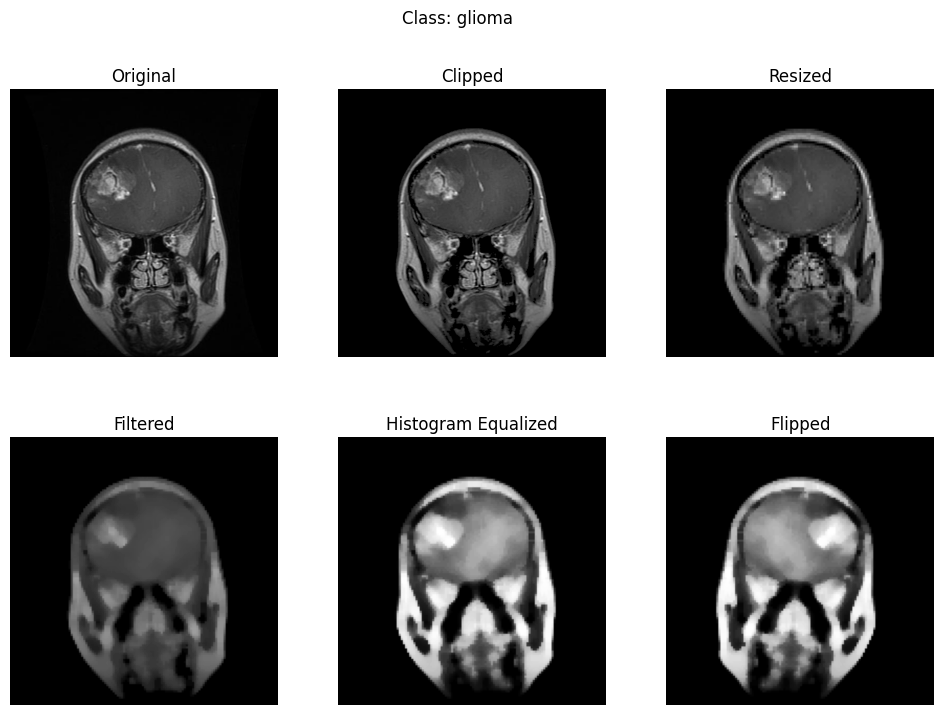

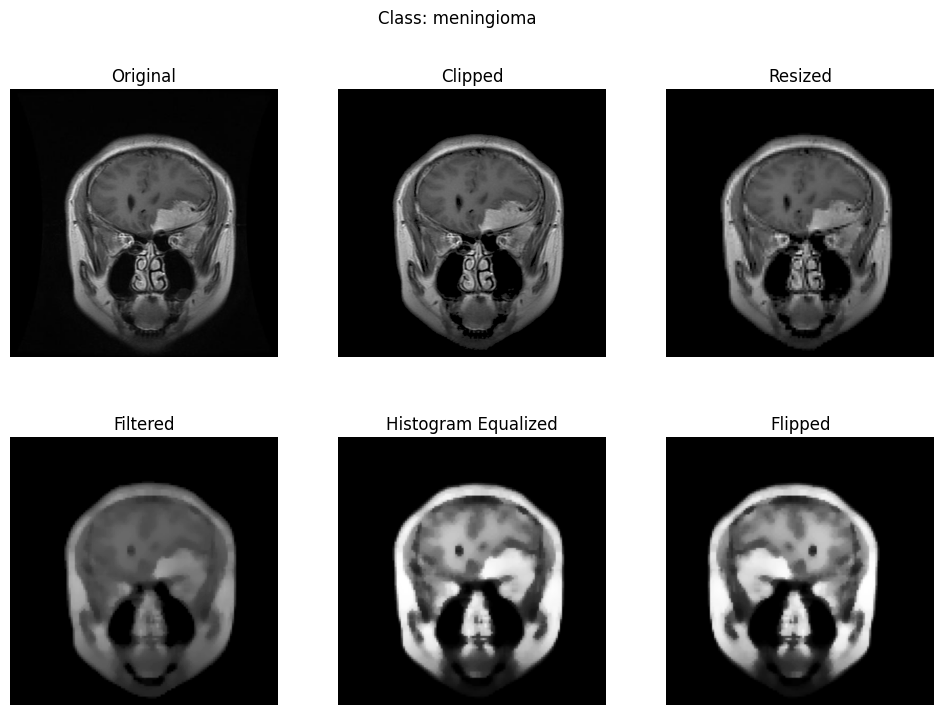

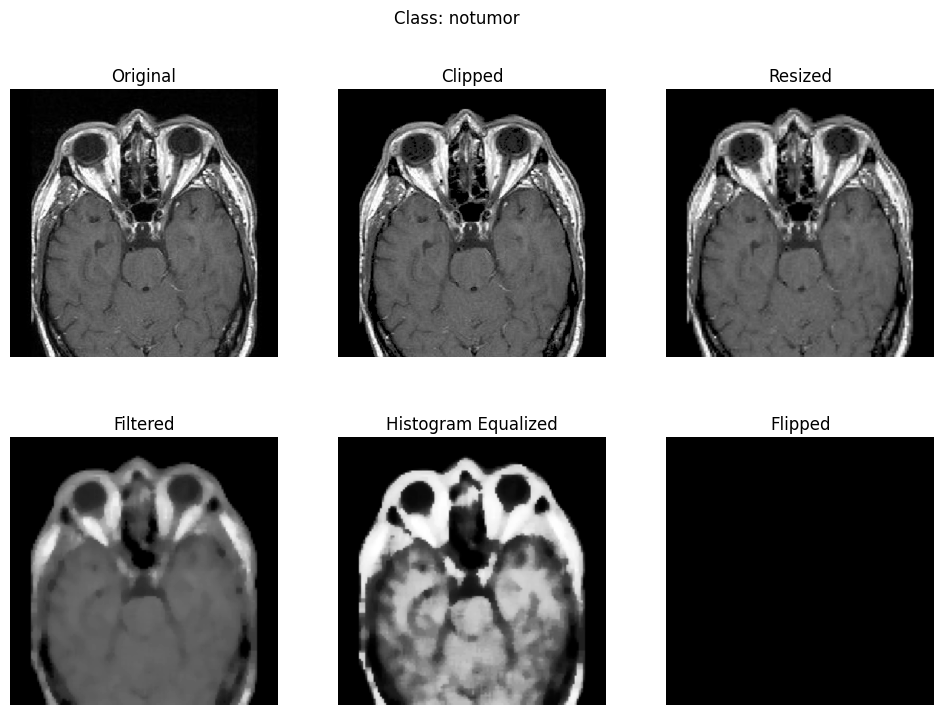

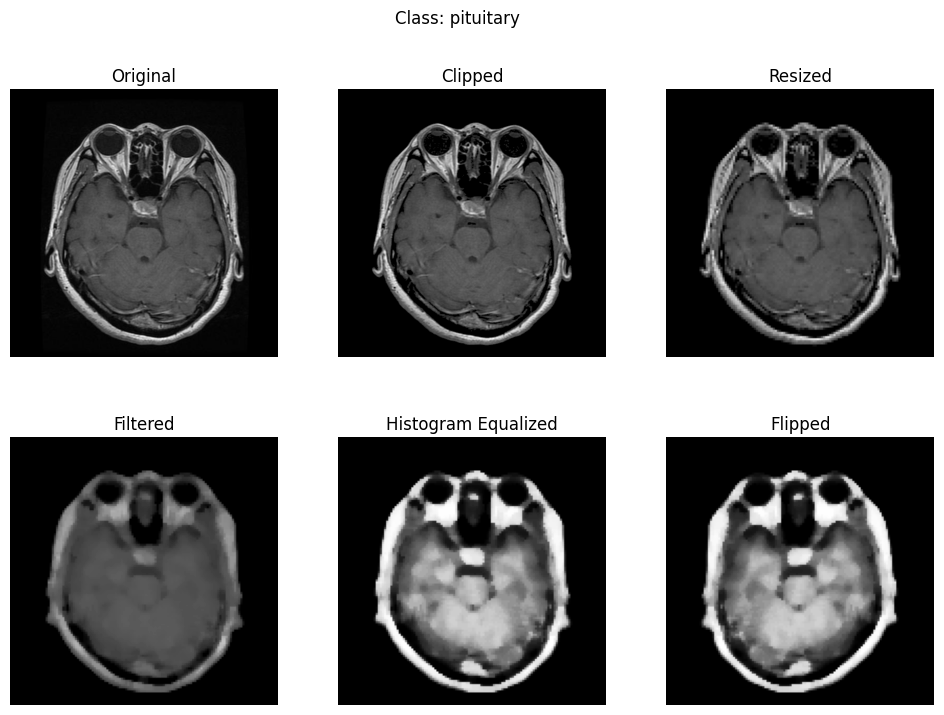

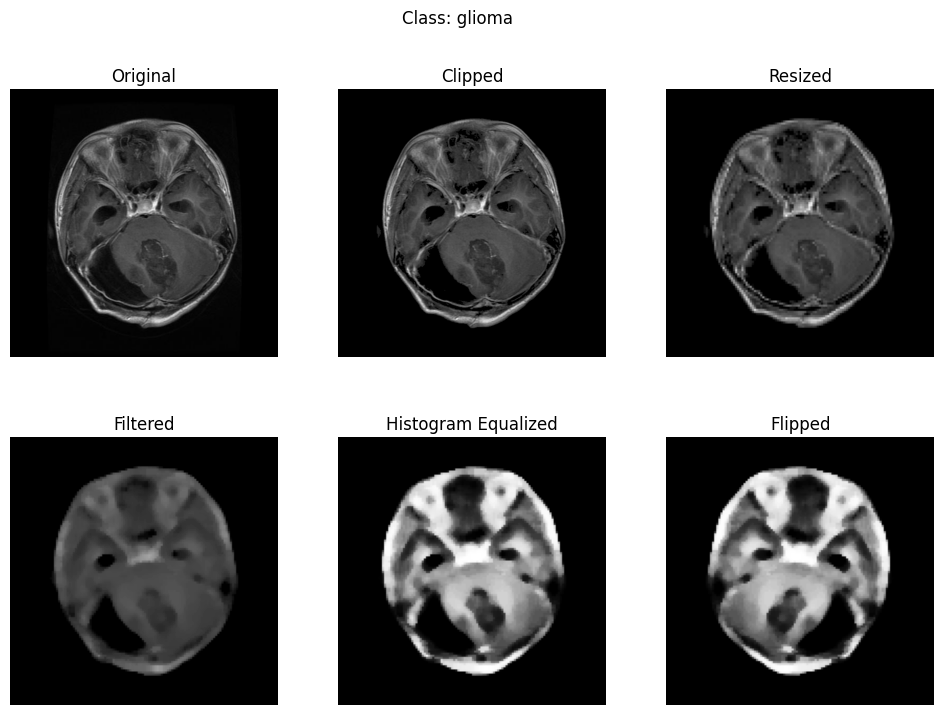

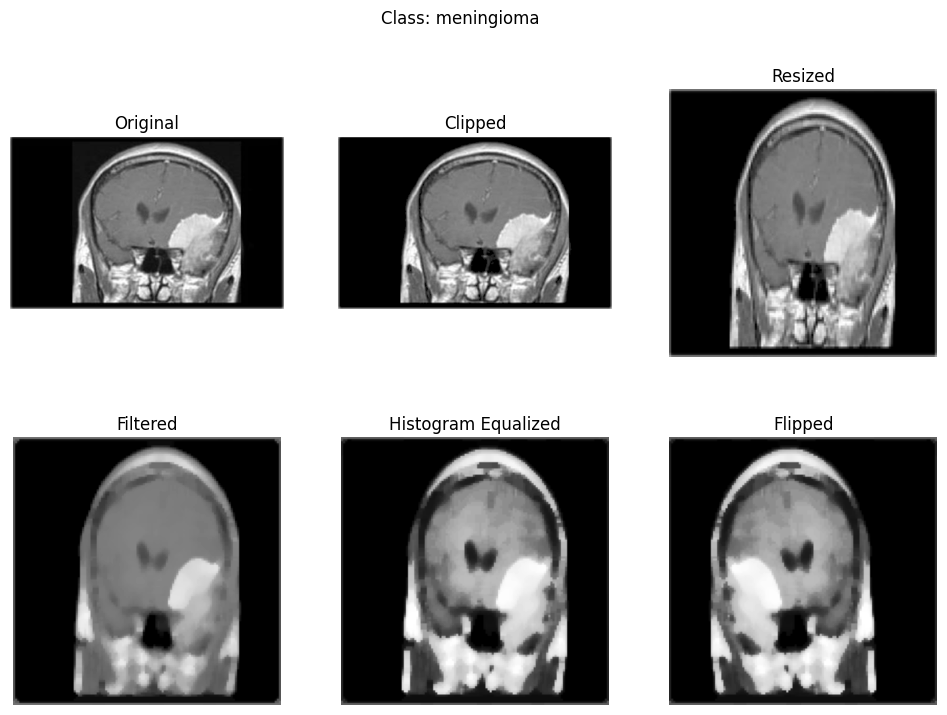

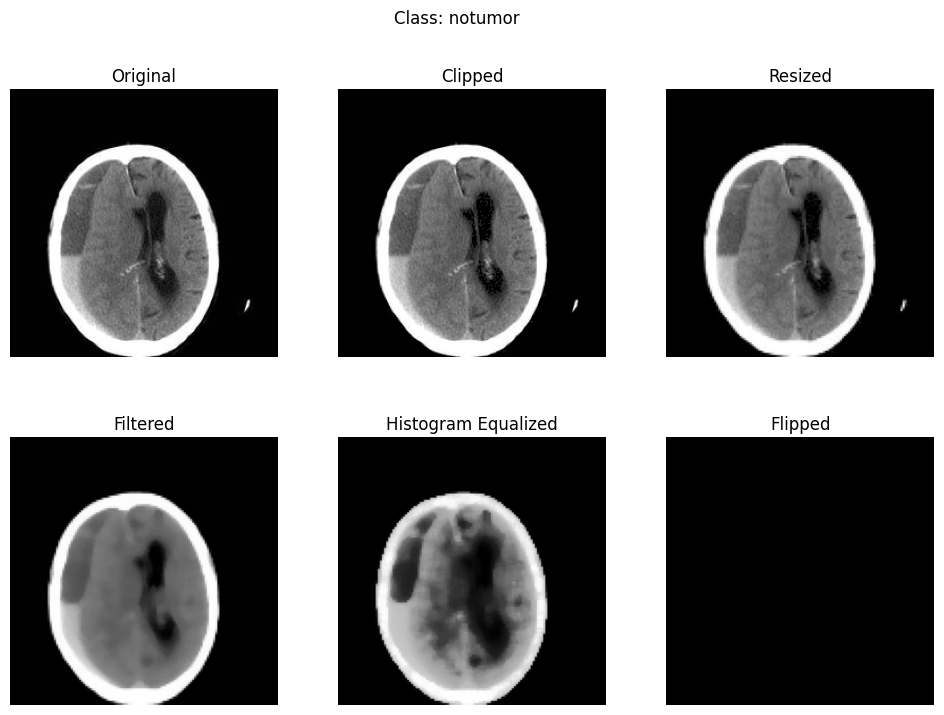

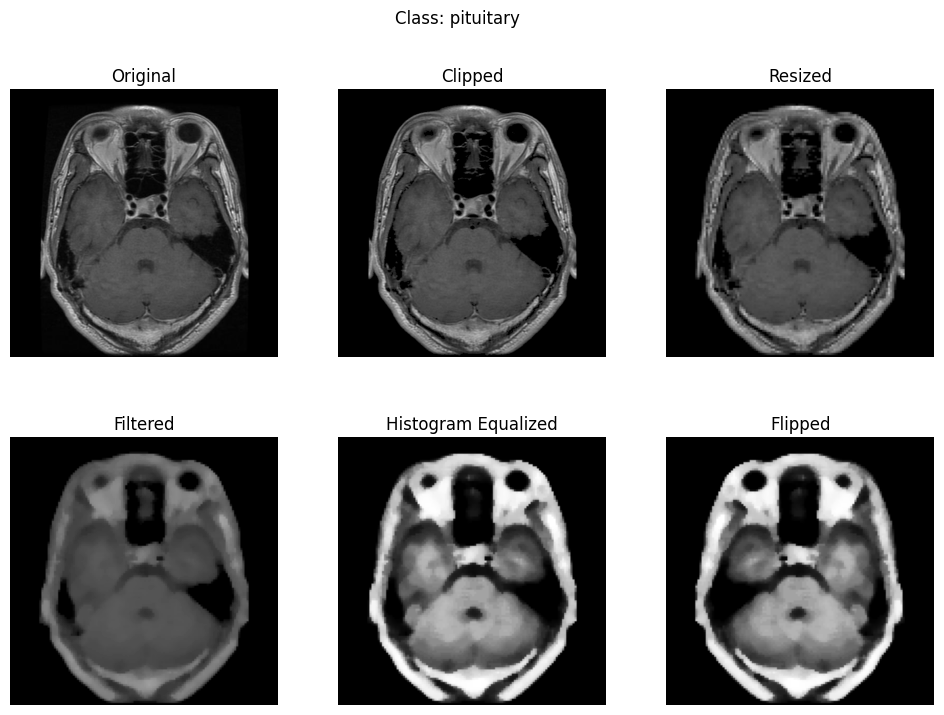

First training sample: Image shape: (16384,), Label: glioma
Number of training samples: 9603
Number of testing samples: 1311


In [27]:
main_directory = "agyikepek_4_osztaly"
train_directory = os.path.join(main_directory, "Training")
test_directory = os.path.join(main_directory, "Testing")


def load_images_and_labels(folder_path, filter_size=5, threshold_value=30, resolution = 128, add_flipped = True):
    data = []
    class_names = os.listdir(folder_path)

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)

        if os.path.isdir(class_folder):
            display_count = 0

            for img_name in os.listdir(class_folder):

                img_path = os.path.join(class_folder, img_name)
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None:
                        images = []

                        # Clipping
                        img_clipped = np.where(img >= threshold_value, img, 0).astype(np.uint8)
                        images.append(img_clipped.copy())

                        # Resizing
                        img_resized = cv2.resize(img_clipped, (resolution, resolution))
                        images.append(img_resized.copy())

                        # Median filter
                        img_filtered = cv2.medianBlur(img_resized, filter_size)
                        images.append(img_filtered.copy())

                        # Histogram Equalization
                        img_equalized = cv2.equalizeHist(img_filtered)
                        images.append(img_equalized.copy())

                        # If it's "notumor", add a black image as placeholder for the flipped image
                        if class_name == "notumor":
                            black_image = np.zeros_like(img_equalized)  # Create a black image of the same size
                            images.append(black_image)  # Append the black image as the flipped version
                        else:
                            # Flip the image only if the label is not "notumor"
                            img_flipped = cv2.flip(img_equalized, 1)  # Flip horizontally
                            images.append(img_flipped.copy())

                        # Normalize + Flatten
                        img_normalized = img_equalized.astype(np.float32) / 255.0
                        img_flipped_normalized = img_flipped.astype(np.float32) / 255.0
                        data.append((img_normalized.flatten(), class_name))
                        if add_flipped and class_name != "notumor":  # Only add flipped image for tumor classes
                            data.append((img_flipped_normalized.flatten(), class_name))

                        if display_count < 1:
                            images.insert(0, img.copy())
                            display_image(images, class_name)
                            display_count += 1

                    else:
                        print(f"Could not read image {img_path}")

                except Exception as e:
                    print(f"Error reading image {img_path}: {e}")

    return data

def display_image(images, class_name):
    titles = [
        "Original",
        "Clipped",
        "Resized",
        "Filtered",
        "Histogram Equalized",
        "Flipped"
    ]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)

    fig.suptitle(f"Class: {class_name}")

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        ax.set_title(titles[i])
        ax.axis('off')

    plt.show()

resolution = 128
train_data = load_images_and_labels(train_directory, add_flipped=True, resolution=resolution)
test_data = load_images_and_labels(test_directory, add_flipped=False, resolution=resolution)

print(f"First training sample: Image shape: {train_data[0][0].shape}, Label: {train_data[0][1]}")

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")


# Ellipszis alakú szegmentálást

Training sample
 label
pituitary     2688
meningioma    2678
glioma        2642
notumor       1595
Name: count, dtype: int64


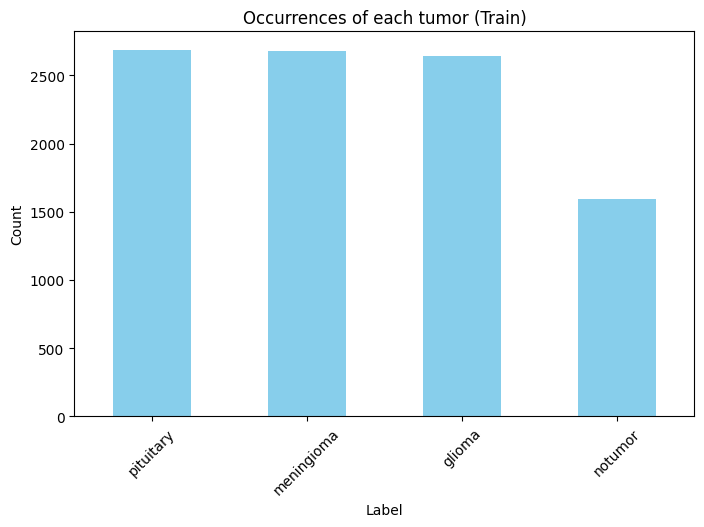



Testing sample
 label
notumor       405
meningioma    306
glioma        300
pituitary     300
Name: count, dtype: int64


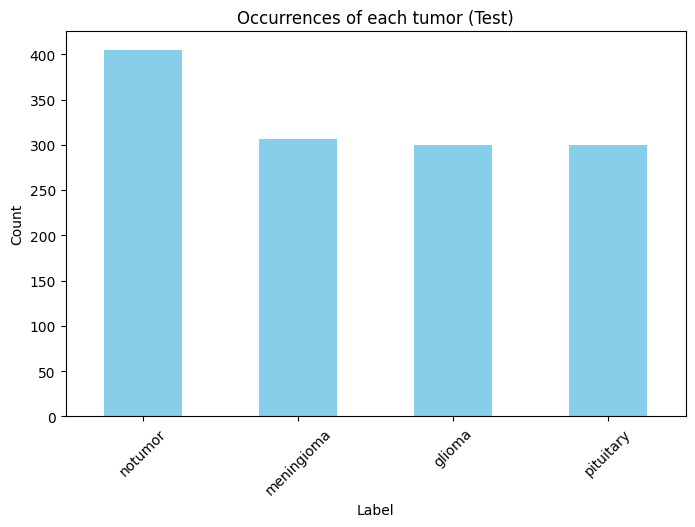

In [28]:
train_df = pd.DataFrame(train_data, columns=["image", "label"])
test_df = pd.DataFrame(test_data, columns=["image", "label"])

train_value_counts = train_df['label'].value_counts()
test_value_counts = test_df['label'].value_counts()


print("Training sample\n", train_value_counts)
plt.figure(figsize=(8,5))
train_value_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Occurrences of each tumor (Train)')
plt.xticks(rotation=45)

plt.show()



print("\n\nTesting sample\n", test_value_counts)
plt.figure(figsize=(8,5))
test_value_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Occurrences of each tumor (Test)')
plt.xticks(rotation=45)

plt.show()



RandomForestClassifier

In [29]:
X_train = [item[0] for item in train_data]
y_train = [item[1] for item in train_data]

X_test = [item[0] for item in test_data]
y_test = [item[1] for item in test_data]

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

class_weights = {0: 1, 1: 1, 2: 5, 3: 1}
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight=class_weights)
rf.fit(X_train, y_train_encoded)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9664


In [30]:
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')
print(f1)

class_names = le.classes_

print(classification_report(y_test_encoded, y_test_pred, target_names=class_names, digits=6))

0.9661349693888945
              precision    recall  f1-score   support

      glioma   0.985240  0.890000  0.935201       300
  meningioma   0.931250  0.973856  0.952077       306
     notumor   0.995074  0.997531  0.996301       405
   pituitary   0.949045  0.993333  0.970684       300

    accuracy                       0.966438      1311
   macro avg   0.965152  0.963680  0.963566      1311
weighted avg   0.967393  0.966438  0.966135      1311



In [31]:
for idx, label in enumerate(le.classes_):
    print(f"{label} -> {idx}")

glioma -> 0
meningioma -> 1
notumor -> 2
pituitary -> 3


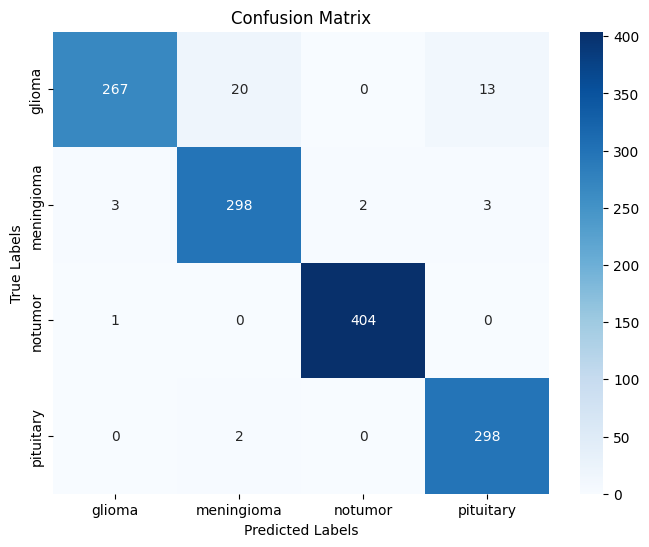

In [32]:
class_names = le.classes_
cm = confusion_matrix(y_test_encoded, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Logistic Regression

In [33]:
lr = LogisticRegression(multi_class='ovr', class_weight=class_weights, n_jobs=-1)

lr.fit(X_train, y_train_encoded)

lr_y_pred = lr.predict(X_test)

lr_accuracy = accuracy_score(y_test_encoded, lr_y_pred)
print(lr_accuracy)

C:\Users\Armand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


0.8901601830663616


In [34]:
print(classification_report(y_test_encoded, lr_y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.85      0.77      0.81       300
  meningioma       0.83      0.79      0.81       306
     notumor       0.92      0.99      0.95       405
   pituitary       0.95      0.98      0.96       300

    accuracy                           0.89      1311
   macro avg       0.89      0.88      0.88      1311
weighted avg       0.89      0.89      0.89      1311

